In [1]:
import gym
import random
import numpy as np   
import matplotlib.pyplot as plt
import collections
import pygame

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import load_model


# disable eager execution (optimization)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# ###### Tensorflow-GPU ########
try:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("No GPU found")


No GPU found


# Double DQN

In [2]:
class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'E'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'E'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance * 1000
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [15]:
class DQAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())


    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
      model = Sequential()
      model.add(Dense(32, input_shape=self.input_shape, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(32, activation='relu'))
      model.add(Dense(self.output_shape, activation='linear'))
      model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate), metrics=['MeanSquaredError'])
      return model

    def policy_network_fit(self, batch, batch_size):
            states, actions, rewards, next_states, dones = zip(*batch)

            states = np.array(states)
            next_states = np.array(next_states)

            # Predict Q-values for starting state using the policy network
            q_values = self.policy_model.predict(states)

            # Predict Q-values for next state using the policy network
            q_values_next_state_policy = self.policy_model.predict(next_states)

            # Select the best action for the next state using the policy network
            best_actions = np.argmax(q_values_next_state_policy, axis=1)

            # Predict Q-values for next state using the target network
            q_values_next_state_target = self.target_model.predict(next_states)

            # Update Q-values for actions taken
            for i in range(batch_size):
                if dones[i]:
                    q_values[i, actions[i]] = rewards[i]
                else:
                    # Double DQN update rule
                    q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

            # Train the policy network
            self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [16]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 20000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.99993
EPISODE_AMOUNT = 170



# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    
    # early stopping
    # if len(reward_history) > 10:
    #     last_10_rewards = reward_history[-10:]
    #     if all(reward > 0 for reward in last_10_rewards):
    #         differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
    #         if all(diff < 200 for diff in differences):
    #             print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
    #             break
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            agent.policy_network_fit(miniBatch_states, y, batch_size=BATCH_SIZE)
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

2024-01-15 09:44:56.044079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 09:44:56.044177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 09:44:56.044217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

episodeReward for episode  0 =  -1827.4637301425705 with epsilon =  0.9313105653335852
episodeReward for episode  1 =  -606.7575232499382 with epsilon =  0.9011679575628045
episodeReward for episode  2 =  -998.566537993184 with epsilon =  0.8689541643267257
episodeReward for episode  3 =  -28.47839240663984 with epsilon =  0.8378332559104105
episodeReward for episode  4 =  635.1801011180077 with epsilon =  0.826821340956385
episodeReward for episode  5 =  -694.1923054619722 with epsilon =  0.8009011443689735
episodeReward for episode  6 =  716.5549709272075 with epsilon =  0.7857407121940392
episodeReward for episode  7 =  93.72426780518049 with epsilon =  0.7694655036558129
episodeReward for episode  8 =  -2035.2855395027577 with epsilon =  0.7116408702101266
episodeReward for episode  9 =  841.1499600749269 with epsilon =  0.7055891231065862
episodeReward for episode  10 =  310.23357171418337 with epsilon =  0.6867787196310973
episodeReward for episode  11 =  641.0463513560799 with e

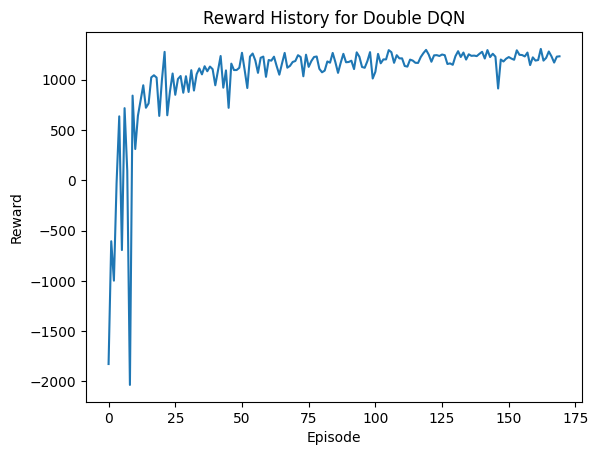

In [17]:
# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for Double DQN')
plt.show()


In [18]:
#save model
agent.policy_model.save('./models/DDQN_RCmaze.h5')


/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))

test_agent.policy_model = load_model('./models/DDQN_RCmaze.h5')

done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()

2024-01-15 09:48:42.285398: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_21/kernel/Assign' id:1492 op device:{requested: '', assigned: ''} def:{{{node dense_21/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_21/kernel, dense_21/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-15 09:48:42.374414: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_6_1/kernel/Assign' id:1839 op device:{requested: '', assigned: ''} def:{{{node dense_6_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_6_1/kernel, dense_6_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation 

done in  34 steps
1296.992428778307


# training with failsafe

## environment


In [3]:
class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'E'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'E'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        
        if action == 0:
            self.move_forward()
        elif action == 1:  # Turn left
            self.turn_left()
        elif action == 2:  # Turn right
            self.turn_right()
            
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        
        # Check sensor reading in the direction of car's orientation
        if self.sensor_readings['front'] <= 4:
            # If the sensor reading is 4 or less, do not move forward
            return
        
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance * 1000
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self,render_mode='human', framerate=60, delay=0):
        if render_mode == 'human':
            # Render the environment using Pygame
            for y in range(self.maze_size_y):
                for x in range(self.maze_size_x):
                    rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                    if (x, y) == self.goal:  # Goal position
                        color = (0, 255, 0)  # Green color for the goal
                    elif self.maze[y][x] == 0:
                        color = (255, 255, 255)  # White color for empty space
                    else:
                        color = (0, 0, 0)  # Black color for walls
                    pygame.draw.rect(self.screen, color, rect)
            
            # Draw the car
            car_x, car_y = self.car_position
            car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
            pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
            pygame.time.delay(delay)
            pygame.display.flip()
            self.clock.tick(framerate)  # Limit the frame rate to 60 FPS
        elif render_mode == 'rgb_array':
            rendered_maze = np.array(self.maze, dtype=str)
            x, y = self.car_position
            rendered_maze[y][x] = 'C'  # Representing the car
            #print array
            print(rendered_maze, '\n')


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

## agent

In [4]:
class DQNAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())


    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
      model = Sequential()
      model.add(Dense(32, input_shape=self.input_shape, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(32, activation='relu'))
      model.add(Dense(self.output_shape, activation='linear'))
      model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate), metrics=['mse', 'loss'])
      return model

    def policy_network_fit(self, batch, batch_size):
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        # Predict Q-values for starting state using the policy network
        q_values = self.policy_model.predict(states)

        # Predict Q-values for next state using the policy network
        q_values_next_state_policy = self.policy_model.predict(next_states)

        # Select the best action for the next state using the policy network
        best_actions = np.argmax(q_values_next_state_policy, axis=1)

        # Predict Q-values for next state using the target network
        q_values_next_state_target = self.target_model.predict(next_states)

        # Update Q-values for actions taken
        for i in range(batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                # Double DQN update rule
                q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

        # Train the policy network
        History = self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)
        return History

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

## training

In [14]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 2000000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)

# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.99933
EPISODE_AMOUNT = 170

# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []
loss_history = []
epsilon_history = []
mse_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            #fit model
            history = agent.policy_network_fit(miniBatch, BATCH_SIZE)
            
            loss_history.append(history.history['loss'])
            mse_history.append(history.history['MeanSquaredError'])
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

2024-01-25 08:40:12.730019: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_33/kernel/Assign' id:2409 op device:{requested: '', assigned: ''} def:{{{node dense_33/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_33/kernel, dense_33/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-25 08:40:13.220055: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_35/BiasAdd' id:2467 op device:{requested: '', assigned: ''} def:{{{node dense_35/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_35/MatMul, dense_35/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in th

episodeReward for episode  0 =  -11187.577529547394 with epsilon =  0.8131032119084998
episodeReward for episode  1 =  -3412.613088363147 with epsilon =  0.7087573648301454
episodeReward for episode  2 =  401.35040739079807 with epsilon =  0.6911676174868705
episodeReward for episode  3 =  -1361.8153441215636 with epsilon =  0.6244547156873305
episodeReward for episode  4 =  1141.1752120511528 with epsilon =  0.6124198844060983
episodeReward for episode  5 =  1049.9125929977574 with epsilon =  0.6086162360645607
episodeReward for episode  6 =  1063.908622113178 with epsilon =  0.6029761169945931
episodeReward for episode  7 =  1145.7134766594077 with epsilon =  0.5973882655790821
episodeReward for episode  8 =  1287.645784210552 with epsilon =  0.5856700460914523
episodeReward for episode  9 =  1034.5343365639665 with epsilon =  0.5783366442940098
episodeReward for episode  10 =  1054.3761253862244 with epsilon =  0.5685023963643897
episodeReward for episode  11 =  384.76614762452607 w

In [15]:
env.close_pygame()

## results

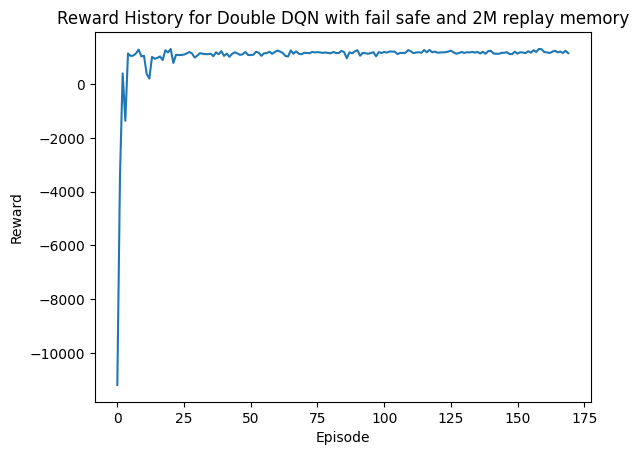

In [16]:
# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for Double DQN with fail safe and 2M replay memory')
plt.show()


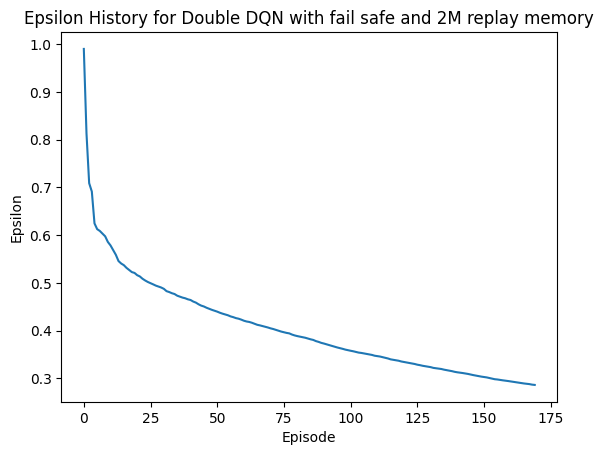

In [21]:
#plot epsilon over time
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon History for Double DQN with fail safe and 2M replay memory')
plt.show()

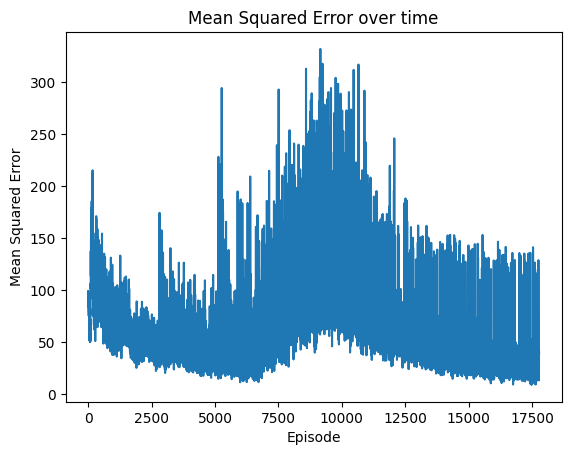

In [17]:
# evalution 

#plot mse 
plt.plot(mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error over time')
plt.show()


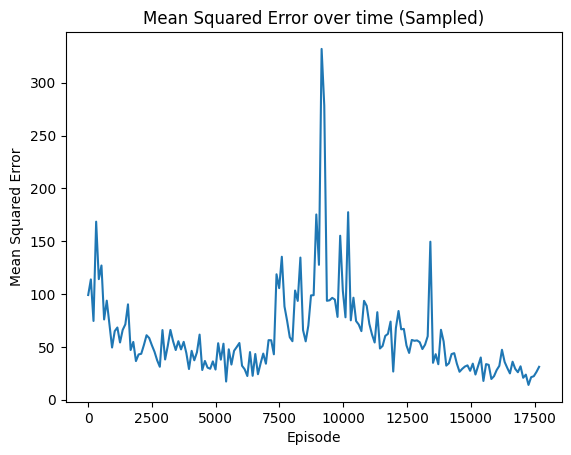

In [25]:
# Assuming mse_history is a flat list with the correct number of elements
EPISODE_AMOUNT = len(mse_history)  # Make sure this reflects the actual number of episodes
desired_samples = 170  # The number of points you want to plot

# Calculate the step size
step = max(EPISODE_AMOUNT // desired_samples, 1)  # Avoid division by zero
sampled_mse_history = mse_history[::step]

# Ensure sampled_episodes has the same number of elements as sampled_mse_history
sampled_episodes = list(range(0, EPISODE_AMOUNT, step))[:len(sampled_mse_history)]

plt.plot(sampled_episodes, sampled_mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error over time (Sampled)')
plt.show()


In [28]:
# save model
agent.policy_model.save('../models/DDQN_RCmaze_v3.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## test

In [29]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))

test_agent.policy_model = load_model('../models/DDQN_RCmaze_v3.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()

2024-01-25 08:57:05.630346: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_53/bias/Assign' id:3468 op device:{requested: '', assigned: ''} def:{{{node dense_53/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_53/bias, dense_53/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-25 08:57:05.816132: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_32_1/bias/Assign' id:3628 op device:{requested: '', assigned: ''} def:{{{node dense_32_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_32_1/bias, dense_32_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in 

done in  25 steps
1240.5006973297018


In [97]:
test_agent.policy_model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 32)                224       
                                                                 
 dense_201 (Dense)           (None, 64)                2112      
                                                                 
 dense_202 (Dense)           (None, 32)                2080      
                                                                 
 dense_203 (Dense)           (None, 3)                 99        
                                                                 
Total params: 4515 (17.64 KB)
Trainable params: 4515 (17.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [98]:
test_agent.policy_model.save('./main_web_app/models/DDQN_RCmaze_v2.h5')

/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## hyper parameter tuning

In [87]:
def evaluate_agent_performance(agent, env, num_eval_episodes=10):
    """
    Evaluates the performance of the agent over a specified number of episodes.
    
    Parameters:
        agent: The trained DQN agent.
        env: The environment in which to evaluate the agent.
        num_eval_episodes (int): Number of episodes to run for the evaluation.
        
    Returns:
        float: The average reward achieved by the agent over the evaluation episodes.
    """
    total_reward = 0.0

    for episode in range(num_eval_episodes):
        state = env.reset()
        episode_reward = 0.0
        done = False

        while not done:
            # For evaluation, choose the best action (no exploration)
            q_values = agent.policy_network_predict(state.reshape(1, -1))
            action = np.argmax(q_values[0])

            state, reward, done = env.step(action)
            episode_reward += reward

        total_reward += episode_reward

    average_reward = total_reward / num_eval_episodes
    return average_reward

In [91]:
# Hyperparameter ranges
learning_rate_options = np.linspace(0.0001, 0.1, 100)
discount_factor_options = np.linspace(0.8, 0.99, 20)
batch_size_options = [32, 64, 128, 256]
epsilon_decay_options = np.linspace(0.995, 0.99999, 50)
epsilon_options =  [0.99, 0.8, 0.5]
min_epsilon_options = np.linspace(0.01, 0.1, 10)
replay_memory_capacity_options = range(10000, 50001, 5000)
update_target_interval_options = range(1, 6)


num_random_search_iters = 10  # Define how many random configurations you want to try

best_performance = float('-inf')
best_hyperparameters = None

for search_iter in range(num_random_search_iters):
    # Randomly select hyperparameters for this iteration
    learning_rate = np.random.choice(learning_rate_options)
    discount_factor = np.random.choice(discount_factor_options)
    batch_size = np.random.choice(batch_size_options)
    epsilon_decay = np.random.choice(epsilon_decay_options)
    min_epsilon = np.random.choice(min_epsilon_options)
    replay_memory_capacity = int(np.random.choice(replay_memory_capacity_options))
    update_target_interval = np.random.choice(update_target_interval_options)
    epsilon = np.random.choice(epsilon_options)

    print(f"Iteration {search_iter + 1}/{num_random_search_iters}")
    print(f"Learning Rate: {learning_rate}, Discount Factor: {discount_factor}, "
          f"Batch Size: {batch_size}, Epsilon Decay: {epsilon_decay}, "
          f"Min Epsilon: {min_epsilon}, Replay Memory Capacity: {replay_memory_capacity}, "
          f"Update Target Interval: {update_target_interval}")

    # Initialize the environment and the DQN agent with the selected hyperparameters
    env = RCMazeEnv()
    state = env.reset()
    env.init_pygame()
    agent = DQNAgent(replayCapacity=replay_memory_capacity,
                     input_shape=state.shape,
                     output_shape=len(env.possible_actions),
                     learning_rate=learning_rate,
                     discount_factor=discount_factor)

 

    # ... (Insert the rest of your existing DQN training loop here)
    # Make sure to replace hard-coded hyperparameters in the training loop
    # with the variables defined above, like `learning_rate`, `batch_size`, etc.
    update_counter = 0
    reward_history = []
    epsilon_history = []

    np.set_printoptions(precision=3, suppress=True)

    for episode in range(20):
        episode_reward = 0
        step_counter = 0  # count the number of successful steps within the episode
        
        state = env.reset()
        done = False
        epsilon_history.append(epsilon)
        
        # early stopping
        # if len(reward_history) > 10:
        #     last_10_rewards = reward_history[-10:]
        #     if all(reward > 0 for reward in last_10_rewards):
        #         differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
        #         if all(diff < 200 for diff in differences):
        #             print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
        #             break
        while not done:
            env.render(delay=0, framerate=360)

            if random.random() <= epsilon:
                action = random.sample(POSSIBLE_ACTIONS, 1)[0]
            else:
                qValues = agent.policy_network_predict(state.reshape(1,-1))
                action = np.argmax(qValues[0])

            new_state, reward, done = env.step(action)

            step_counter +=1

            # store step in replay memory
            step = (state, action, reward, new_state, done)
            agent.addToReplayMemory(step)
            state = new_state
            episode_reward += reward
            # When enough steps in replay memory -> train policy network
            if len(agent.memory) >= (batch_size):
                # Update epsilon after each episode, not each training step
                if episode % 10 == 0 and epsilon > min_epsilon:
                    epsilon *= epsilon_decay
                # sample minibatch from replay memory
                
                miniBatch = agent.sampleFromReplayMemory(batch_size)
                miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
                miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
                miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
                miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
                miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
                
                # current state q values1tch_states)
                y = agent.policy_network_predict(miniBatch_states)

                next_state_q_values = agent.target_network_predict(miniBatch_next_state)
                max_q_next_state = np.max(next_state_q_values,axis=1)

                for i in range(batch_size):
                    if miniBatch_done[i]:
                        y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                    else:
                        y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + discount_factor *  max_q_next_state[i]
                        
                agent.policy_model.fit(miniBatch_states, y, batch_size=batch_size, verbose = 0)
                
            else:
                continue
            if update_counter == update_target_interval:
                agent.update_target_network()
                update_counter = 0
            update_counter += 1
        print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', epsilon)
        reward_history.append(episode_reward)

    # After training, evaluate the performance of the agent
    current_performance = evaluate_agent_performance(agent, env)  # Define this function as per your evaluation metric

    if current_performance > best_performance:
        best_performance = current_performance
        best_hyperparameters = {
            "learning_rate": learning_rate,
            "discount_factor": discount_factor,
            "batch_size": batch_size,
            "epsilon_decay": epsilon_decay,
            "min_epsilon": min_epsilon,
            "replay_memory_capacity": replay_memory_capacity,
            "update_target_interval": update_target_interval
        }

    env.close_pygame()
    env.close()

# After all iterations, print out the best performing hyperparameters
print("Best Hyperparameters found:")
print(best_hyperparameters)



Iteration 1/10
Learning Rate: 0.06468181818181819, Discount Factor: 0.99, Batch Size: 32, Epsilon Decay: 0.9960183673469388, Min Epsilon: 0.1, Replay Memory Capacity: 15000, Update Target Interval: 3


2024-01-17 11:32:16.179133: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_324/kernel/Assign' id:24339 op device:{requested: '', assigned: ''} def:{{{node dense_324/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_324/kernel, dense_324/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-17 11:32:16.849519: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_323/BiasAdd' id:24282 op device:{requested: '', assigned: ''}

episodeReward for episode  0 =  -4186.683873939 with epsilon =  0.09968854039978094
episodeReward for episode  1 =  -14022.919205623848 with epsilon =  0.09968854039978094
episodeReward for episode  2 =  -4086.6738477236513 with epsilon =  0.09968854039978094
episodeReward for episode  3 =  -14300.573130031802 with epsilon =  0.09968854039978094
episodeReward for episode  4 =  -5624.371420756949 with epsilon =  0.09968854039978094
episodeReward for episode  5 =  -14451.578469011482 with epsilon =  0.09968854039978094
episodeReward for episode  6 =  -11357.164240105234 with epsilon =  0.09968854039978094
episodeReward for episode  7 =  -6607.744494760525 with epsilon =  0.09968854039978094
episodeReward for episode  8 =  -1994.086775497702 with epsilon =  0.09968854039978094
episodeReward for episode  9 =  -14579.802293604627 with epsilon =  0.09968854039978094
episodeReward for episode  10 =  -3490.0712451936233 with epsilon =  0.09968854039978094
episodeReward for episode  11 =  -178.

2024-01-17 11:38:28.037914: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_335/bias/Assign' id:25009 op device:{requested: '', assigned: ''} def:{{{node dense_335/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_335/bias, dense_335/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 11:38:28.705073: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_331/BiasAdd' id:24875 op device:{requested: '', assigned: ''} def:{{{node dense_331/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_331/MatMul, dense_331/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either 

episodeReward for episode  0 =  -5104.382640510846 with epsilon =  0.00999022247845212
episodeReward for episode  1 =  -23900.098715664306 with epsilon =  0.00999022247845212
episodeReward for episode  2 =  -23943.97707612456 with epsilon =  0.00999022247845212
episodeReward for episode  3 =  -23668.979449372953 with epsilon =  0.00999022247845212
episodeReward for episode  4 =  -21443.66158236873 with epsilon =  0.00999022247845212
episodeReward for episode  5 =  -21402.45481706249 with epsilon =  0.00999022247845212
episodeReward for episode  6 =  -21644.127977027896 with epsilon =  0.00999022247845212
episodeReward for episode  7 =  -18553.36045517816 with epsilon =  0.00999022247845212
episodeReward for episode  8 =  -20643.813839884348 with epsilon =  0.00999022247845212
episodeReward for episode  9 =  -15926.170459264004 with epsilon =  0.00999022247845212
episodeReward for episode  10 =  -19889.52029961911 with epsilon =  0.00999022247845212
episodeReward for episode  11 =  -209

2024-01-17 11:48:23.066352: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_337/bias/Assign' id:25415 op device:{requested: '', assigned: ''} def:{{{node dense_337/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_337/bias, dense_337/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 11:48:23.712236: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_339/BiasAdd' id:25468 op device:{requested: '', assigned: ''} def:{{{node dense_339/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_339/MatMul, dense_339/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either 

episodeReward for episode  0 =  -13039.17077473326 with epsilon =  0.07983945381656987
episodeReward for episode  1 =  -19069.19092833686 with epsilon =  0.07983945381656987
episodeReward for episode  2 =  -12285.397013227568 with epsilon =  0.07983945381656987
episodeReward for episode  3 =  -9923.261100696003 with epsilon =  0.07983945381656987
episodeReward for episode  4 =  -10241.108246700642 with epsilon =  0.07983945381656987
episodeReward for episode  5 =  -5393.040669606068 with epsilon =  0.07983945381656987
episodeReward for episode  6 =  -13916.34661160804 with epsilon =  0.07983945381656987
episodeReward for episode  7 =  -16699.994816092792 with epsilon =  0.07983945381656987
episodeReward for episode  8 =  -15281.195468288557 with epsilon =  0.07983945381656987
episodeReward for episode  9 =  -14589.739036577334 with epsilon =  0.07983945381656987
episodeReward for episode  10 =  -6025.8050632378645 with epsilon =  0.07983945381656987
episodeReward for episode  11 =  -43

2024-01-17 11:56:10.137482: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_346/kernel/Assign' id:26027 op device:{requested: '', assigned: ''} def:{{{node dense_346/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_346/kernel, dense_346/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 11:56:10.799571: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_347/BiasAdd' id:26061 op device:{requested: '', assigned: ''} def:{{{node dense_347/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_347/MatMul, dense_347/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

episodeReward for episode  0 =  -5057.921090136337 with epsilon =  0.3363270336049504
episodeReward for episode  1 =  -3147.3494464006426 with epsilon =  0.3363270336049504
episodeReward for episode  2 =  -936.425325210928 with epsilon =  0.3363270336049504
episodeReward for episode  3 =  -706.6941910992815 with epsilon =  0.3363270336049504
episodeReward for episode  4 =  -528.3357443278315 with epsilon =  0.3363270336049504
episodeReward for episode  5 =  -498.5050693355373 with epsilon =  0.3363270336049504
episodeReward for episode  6 =  -646.1825422924762 with epsilon =  0.3363270336049504
episodeReward for episode  7 =  -599.5571323846904 with epsilon =  0.3363270336049504
episodeReward for episode  8 =  -496.0909981123989 with epsilon =  0.3363270336049504
episodeReward for episode  9 =  1205.5812595399052 with epsilon =  0.3363270336049504
episodeReward for episode  10 =  -125.93335937933425 with epsilon =  0.13046284547465326
episodeReward for episode  11 =  475.2100180184766 

2024-01-17 12:08:50.705292: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_356/bias/Assign' id:26716 op device:{requested: '', assigned: ''} def:{{{node dense_356/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_356/bias, dense_356/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 12:08:51.395587: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_355/BiasAdd' id:26654 op device:{requested: '', assigned: ''} def:{{{node dense_355/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_355/MatMul, dense_355/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either 

episodeReward for episode  0 =  -7802.6423217264455 with epsilon =  0.04987789694580385
episodeReward for episode  1 =  -15366.000732601127 with epsilon =  0.04987789694580385
episodeReward for episode  2 =  -829.2288656982187 with epsilon =  0.04987789694580385
episodeReward for episode  3 =  -18356.48000362609 with epsilon =  0.04987789694580385
episodeReward for episode  4 =  -15312.32238263278 with epsilon =  0.04987789694580385
episodeReward for episode  5 =  -14787.5910918154 with epsilon =  0.04987789694580385
episodeReward for episode  6 =  -15831.562903086766 with epsilon =  0.04987789694580385
episodeReward for episode  7 =  -4907.726464320114 with epsilon =  0.04987789694580385
episodeReward for episode  8 =  -15093.048231330149 with epsilon =  0.04987789694580385
episodeReward for episode  9 =  -17268.81418150366 with epsilon =  0.04987789694580385
episodeReward for episode  10 =  -4552.236585968762 with epsilon =  0.04987789694580385
episodeReward for episode  11 =  -15938

2024-01-17 12:26:51.280794: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_360/kernel/Assign' id:27165 op device:{requested: '', assigned: ''} def:{{{node dense_360/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_360/kernel, dense_360/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 12:26:52.212866: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_363/BiasAdd' id:27247 op device:{requested: '', assigned: ''} def:{{{node dense_363/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_363/MatMul, dense_363/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

episodeReward for episode  0 =  -13417.480573932868 with epsilon =  0.029987051558754804
episodeReward for episode  1 =  -17580.271907045797 with epsilon =  0.029987051558754804
episodeReward for episode  2 =  -19374.310055039165 with epsilon =  0.029987051558754804
episodeReward for episode  3 =  -19862.726732675896 with epsilon =  0.029987051558754804
episodeReward for episode  4 =  -9535.165990041 with epsilon =  0.029987051558754804
episodeReward for episode  5 =  -16194.277101770944 with epsilon =  0.029987051558754804
episodeReward for episode  6 =  -18813.555071650793 with epsilon =  0.029987051558754804
episodeReward for episode  7 =  -14896.213412570449 with epsilon =  0.029987051558754804
episodeReward for episode  8 =  -18245.655041917304 with epsilon =  0.029987051558754804
episodeReward for episode  9 =  -20486.85300309152 with epsilon =  0.029987051558754804
episodeReward for episode  10 =  -21495.82858402314 with epsilon =  0.029987051558754804
episodeReward for episode 

2024-01-17 12:40:02.254266: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_368/kernel/Assign' id:27758 op device:{requested: '', assigned: ''} def:{{{node dense_368/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_368/kernel, dense_368/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 12:40:03.002329: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_371/BiasAdd' id:27840 op device:{requested: '', assigned: ''} def:{{{node dense_371/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_371/MatMul, dense_371/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

episodeReward for episode  0 =  -13832.654116310578 with epsilon =  0.049922034792869906
episodeReward for episode  1 =  -17199.89227638377 with epsilon =  0.049922034792869906
episodeReward for episode  2 =  -10159.425714894722 with epsilon =  0.049922034792869906
episodeReward for episode  3 =  -5117.895155716674 with epsilon =  0.049922034792869906
episodeReward for episode  4 =  -20415.577010792695 with epsilon =  0.049922034792869906
episodeReward for episode  5 =  -13234.10880612121 with epsilon =  0.049922034792869906
episodeReward for episode  6 =  -4638.858784940201 with epsilon =  0.049922034792869906
episodeReward for episode  7 =  -8580.662262023057 with epsilon =  0.049922034792869906
episodeReward for episode  8 =  -6935.923249790182 with epsilon =  0.049922034792869906
episodeReward for episode  9 =  -15256.32854468294 with epsilon =  0.049922034792869906
episodeReward for episode  10 =  -9018.128972295483 with epsilon =  0.049922034792869906
episodeReward for episode  1

2024-01-17 12:51:11.960006: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_377/kernel/Assign' id:28375 op device:{requested: '', assigned: ''} def:{{{node dense_377/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_377/kernel, dense_377/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 12:51:12.739461: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_379/BiasAdd' id:28433 op device:{requested: '', assigned: ''} def:{{{node dense_379/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_379/MatMul, dense_379/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

episodeReward for episode  0 =  -1942.7068552689484 with epsilon =  0.8846489470446746
episodeReward for episode  1 =  -11484.085349681507 with epsilon =  0.8846489470446746
episodeReward for episode  2 =  -1817.4382167082135 with epsilon =  0.8846489470446746
episodeReward for episode  3 =  -8776.509917528132 with epsilon =  0.8846489470446746
episodeReward for episode  4 =  -1774.0029778035532 with epsilon =  0.8846489470446746
episodeReward for episode  5 =  -6072.112955006758 with epsilon =  0.8846489470446746
episodeReward for episode  6 =  -1411.0931645384608 with epsilon =  0.8846489470446746
episodeReward for episode  7 =  -10051.23063864821 with epsilon =  0.8846489470446746
episodeReward for episode  8 =  -2446.2499001788888 with epsilon =  0.8846489470446746
episodeReward for episode  9 =  -8934.110632031457 with epsilon =  0.8846489470446746
episodeReward for episode  10 =  -9920.642676576254 with epsilon =  0.6324176956343934
episodeReward for episode  11 =  78.84635621450

2024-01-17 13:01:58.755449: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_386/kernel/Assign' id:28992 op device:{requested: '', assigned: ''} def:{{{node dense_386/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_386/kernel, dense_386/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 13:01:59.457924: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_387/BiasAdd' id:29026 op device:{requested: '', assigned: ''} def:{{{node dense_387/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_387/MatMul, dense_387/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

episodeReward for episode  0 =  -10013.653290754964 with epsilon =  0.07999560476172372
episodeReward for episode  1 =  -16590.490038767708 with epsilon =  0.07999560476172372
episodeReward for episode  2 =  -14926.887559367762 with epsilon =  0.07999560476172372
episodeReward for episode  3 =  -5827.571058346457 with epsilon =  0.07999560476172372
episodeReward for episode  4 =  -15470.63816551307 with epsilon =  0.07999560476172372
episodeReward for episode  5 =  -14130.777815566236 with epsilon =  0.07999560476172372
episodeReward for episode  6 =  -11229.045162661878 with epsilon =  0.07999560476172372
episodeReward for episode  7 =  -6345.151604329504 with epsilon =  0.07999560476172372
episodeReward for episode  8 =  -17084.07744051958 with epsilon =  0.07999560476172372
episodeReward for episode  9 =  -16420.547748390025 with epsilon =  0.07999560476172372
episodeReward for episode  10 =  -6094.717579722551 with epsilon =  0.07999560476172372
episodeReward for episode  11 =  -15

2024-01-17 13:09:12.643152: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_395/kernel/Assign' id:29609 op device:{requested: '', assigned: ''} def:{{{node dense_395/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_395/kernel, dense_395/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-17 13:09:13.401804: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_395/BiasAdd' id:29619 op device:{requested: '', assigned: ''} def:{{{node dense_395/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_395/MatMul, dense_395/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

episodeReward for episode  0 =  -14095.818721034251 with epsilon =  0.0699823199441582
episodeReward for episode  1 =  -12530.95366068895 with epsilon =  0.0699823199441582
episodeReward for episode  2 =  -12422.472176278085 with epsilon =  0.0699823199441582
episodeReward for episode  3 =  1552.908288655966 with epsilon =  0.0699823199441582
episodeReward for episode  4 =  -20065.59094608696 with epsilon =  0.0699823199441582
episodeReward for episode  5 =  -19813.42890714481 with epsilon =  0.0699823199441582
episodeReward for episode  6 =  -17744.48269362927 with epsilon =  0.0699823199441582
episodeReward for episode  7 =  -16687.4298258788 with epsilon =  0.0699823199441582
episodeReward for episode  8 =  -9046.863023573374 with epsilon =  0.0699823199441582
episodeReward for episode  9 =  -14580.664519736572 with epsilon =  0.0699823199441582
episodeReward for episode  10 =  -10016.099201432891 with epsilon =  0.0699823199441582
episodeReward for episode  11 =  -9044.751764179673

### testing with best hyper parameters

In [92]:
# make new model with the best hyperparameters
print(best_hyperparameters)

{'learning_rate': 0.06064545454545455, 'discount_factor': 0.92, 'batch_size': 256, 'epsilon_decay': 0.9998881632653062, 'min_epsilon': 0.01, 'replay_memory_capacity': 20000, 'update_target_interval': 4}


In [93]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 2000000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions
# reset the parameters
DISCOUNT = 0.92
BATCH_SIZE = 256  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 4
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.9998881632653062
EPISODE_AMOUNT = 170
LEARNING_RATE = 0.06064545454545455

# state = state[0]
# create DQN agent
agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=LEARNING_RATE, 
                discount_factor=DISCOUNT)





# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            agent.policy_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

2024-01-17 13:33:33.352902: W tensorflow/c/c_api.cc:305] Operation '{name:'total_124/Assign' id:30356 op device:{requested: '', assigned: ''} def:{{{node total_124/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_124, total_124/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-17 13:33:34.409075: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_403/BiasAdd' id:30212 op device:{requested: '', assigned: ''} def:{{{node dense_403/BiasAdd}} = BiasAdd[T=DT

episodeReward for episode  0 =  -562.6959914407755 with epsilon =  0.9521015887850328
episodeReward for episode  1 =  -6779.342488460645 with epsilon =  0.7896252134978342
episodeReward for episode  2 =  -2217.930192354638 with epsilon =  0.7059917753086713
episodeReward for episode  3 =  560.3892368685965 with epsilon =  0.6849145854627794
episodeReward for episode  4 =  -422.09146182632026 with epsilon =  0.6401746133137192
episodeReward for episode  5 =  1037.4210763789133 with epsilon =  0.6300173917980675
episodeReward for episode  6 =  -2155.0935322230775 with epsilon =  0.5574602471269431
episodeReward for episode  7 =  -5392.503390570234 with epsilon =  0.486846722644997
episodeReward for episode  8 =  716.8066582262354 with epsilon =  0.4774639480385564
episodeReward for episode  9 =  1155.5678167940846 with epsilon =  0.4718896386124908
episodeReward for episode  10 =  1081.3744662836082 with epsilon =  0.46638040828968547
episodeReward for episode  11 =  1274.71635965106 wit

KeyboardInterrupt: 

### results after training with best hyper parameters

In [ ]:
## plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for Double DQN after hyperparameter tuning')
plt.show()


In [ ]:
# save model
agent.policy_model.save('./models/DDQN_RCmaze_HPT.h5')

### testing with best hyper parameters

In [ ]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))

test_agent.policy_model = load_model('./models/DDQN_RCmaze_HPT.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()